In [16]:
#libraries
import numpy as np 
import pandas as pd 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import ShuffleSplit, KFold
from sklearn.model_selection import cross_val_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mlcourse-dota2-win-prediction/sample_submission.csv
/kaggle/input/mlcourse-dota2-win-prediction/train_matches.jsonl
/kaggle/input/mlcourse-dota2-win-prediction/test_matches.jsonl
/kaggle/input/mlcourse-dota2-win-prediction/train_features.csv
/kaggle/input/mlcourse-dota2-win-prediction/test_features.csv
/kaggle/input/mlcourse-dota2-win-prediction/train_targets.csv


In [17]:
%%time
PATH_TO_DATA = '../input/mlcourse-dota2-win-prediction'
df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA,'train_features.csv'), index_col='match_id_hash')
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_targets.csv'), index_col='match_id_hash')

CPU times: user 1.29 s, sys: 114 ms, total: 1.4 s
Wall time: 1.4 s


In [18]:
df_train_features.shape, df_train_targets.shape

((39675, 245), (39675, 5))

In [19]:
df_train_features.head()
df_train_features.tail()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,3,1,9,9,0,...,26.493834,6,2,3,0,0.5625,0,0,7,2
bc7a87ed5f9c2bca55f9f7a93da0b0c5,377,22,7,1,0,14,0,2,1,1,...,0.000000,0,0,1,0,0.0000,0,0,0,0
e2ca68ac1a6847f4a37f6c9c8ee8695b,643,22,7,1,23,63,1,4,0,2,...,2.532715,0,0,3,1,0.5000,0,0,1,0
47ad6454ede66c1c78fdaa9391dfc556,2405,22,7,12,4,22,3,8,14,7,...,17.583984,3,1,4,0,0.6250,0,0,0,0
9928dfde50efcbdb2055da23dcdbc101,1775,22,0,10,13,32,3,4,15,0,...,8.331238,0,0,1,0,0.5500,1,0,0,0


In [20]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
46a0ddce8f7ed2a8d9bd5edcbb925682,576,True,1952,1376,NaN
b1b35ff97723d9b7ade1c9c3cf48f770,453,False,2001,1548,NaN


In [21]:
X = df_train_features.values
y = df_train_targets['radiant_win'].values

print(X)
print(y)

[[1.550e+02 2.200e+01 7.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [6.580e+02 4.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.100e+01 2.300e+01 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [6.430e+02 2.200e+01 7.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
 [2.405e+03 2.200e+01 7.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [1.775e+03 2.200e+01 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
[False  True  True ... False  True  True]
0.7041461877756774


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [22]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3,random_state=17)

In [23]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((27772, 245), (11903, 245), (27772,), (11903,))

In [24]:
np.bincount(y)

array([18849, 20826])

In [52]:
#Logistic Regression + Ridge Regression with PCA
C = 1
penalty = 'l2'
max_iter = 100
solver = 'liblinear'
random_state = 17
n_jobs = -1
verbose = 1

clf_lr = LogisticRegression(C=C,
                            penalty=penalty,
                            max_iter=max_iter, 
                            random_state=random_state,
                            verbose=verbose,
                            n_jobs=n_jobs,
                           solver=solver)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

clf_lr.fit(X_pca, y)


accuracy_pca = clf_lr.score(X_pca, y)
print(accuracy_pca)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]0.7085318210459988


In [53]:
%%time
#Logistic Regression + Ridge Regression without PCA
clf_lr.fit(x_train, y_train)
y_pred = clf_lr.predict(x_valid)
print('Log Regression validation roc_auc score {} '.format(roc_auc_score(y_pred, y_valid)))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]Log Regression validation roc_auc score 0.7266546207314954 
CPU times: user 3min 53s, sys: 67.7 ms, total: 3min 53s
Wall time: 3min 53s


/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [54]:
#Logistic Regression + Lasso Regression with PCA
C = 1
penalty = 'l1'
max_iter = 100
solver = 'liblinear'
random_state = 17
n_jobs = -1
verbose = 1

clf_lr0 = LogisticRegression(C=C,
                            penalty=penalty,
                            max_iter=max_iter, 
                            random_state=random_state,
                            verbose=verbose,
                            n_jobs=n_jobs,
                           solver=solver)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

clf_lr0.fit(X_pca, y)


accuracy_pca_l1 = clf_lr0.score(X_pca, y)
print(accuracy_pca_l1)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]0.709413988657845


In [56]:
#Logistic Regression + Lasso Regression without PCA
clf_lr0.fit(x_train, y_train)
y_pred = clf_lr0.predict(x_valid)
print('Log Regression  + Lasso Regression without PCA validation roc_auc score {} '.format(roc_auc_score(y_pred, y_valid)))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]Log Regression  + Lasso Regression without PCA validation roc_auc score 0.7254106627890032 


In [57]:
C = 1
penalty = 'l2'
max_iter = 50
solver = 'liblinear'
random_state = 17
n_jobs = -1
verbose = 1

clf_lr_1 = LogisticRegression(C=C,
                            penalty=penalty,
                            max_iter=max_iter, 
                            random_state=random_state,
                            verbose=verbose,
                            n_jobs=n_jobs,
                           solver=solver)
clf_lr_1.fit(x_train, y_train)
y_pred = clf_lr_1.predict(x_valid)
print('Log Regression with gradient descent  roc_auc score {} '.format(roc_auc_score(y_pred, y_valid)))


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

clf_lr_1.fit(X_pca, y)


accuracy_pca_gd = clf_lr_1.score(X_pca, y)
print(accuracy_pca_gd)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Log Regression with gradient descent  roc_auc score 0.727393974531776 


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]0.7091619407687461


### Performing Cross-Validation

In [27]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=17) #Splits the data into 5 different train-validation pairs (with 30% of the data reserved for validation each time

In [28]:
#calcuating ROC-AUC for each split
C = 1
penalty = 'l2'
max_iter = 50
solver = 'liblinear'
random_state = 17
n_jobs = -1
verbose = 1

clf_lr_1 = LogisticRegression(C=C,
                            penalty=penalty,
                            max_iter=max_iter, 
                            random_state=random_state,
                            verbose=verbose,
                            n_jobs=n_jobs,
                           solver=solver)

cv_scores_lr1 = cross_val_score(clf_lr_1, X, y, cv=cv, scoring='roc_auc')

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [29]:
C = 0.1
penalty = 'l2'
solver = 'saga'
max_iter = 150
random_state = 17
n_jobs = -1
verbose = 1
class_weight = 'balanced'

clf_lr_2 = LogisticRegression(C=C,
                            penalty=penalty,
                            max_iter=max_iter, 
                            random_state=random_state,
                            verbose=verbose,
                            n_jobs=n_jobs,
                            class_weight=class_weight,
                            solver=solver)

# calcuate ROC-AUC for each split
cv_scores_lr2 = cross_val_score(clf_lr_2, X, y, cv=cv, scoring='roc_auc')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   20.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   19.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.3s finished


In [59]:
cv_scores_lr2 > cv_scores_lr1

array([ True, False, False,  True, False])

In [31]:
import json
with open(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')) as f:
    # read the 18-th line
    for i in range(18):
        line = f.readline()
    
    # read JSON into a Python object 
    match = json.loads(line)

In [32]:
player = match['players'][2]
#player

In [33]:
player['kills'], player['deaths'], player['assists']

(8, 11, 12)

In [34]:
player['ability_uses']

{'kunkka_torrent': 43,
 'kunkka_ghostship': 16,
 'kunkka_x_marks_the_spot': 8,
 'kunkka_return': 1}

In [35]:
%matplotlib inline
from matplotlib import pyplot as plt

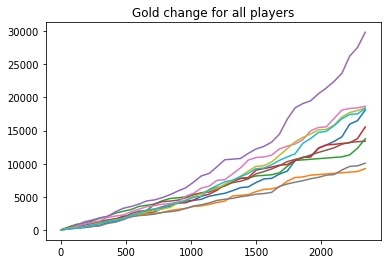

In [36]:
for player in match['players']:
    plt.plot(player['times'], player['gold_t'])
    
plt.title('Gold change for all players');

In [37]:

import json
def read_matches(matches_file):
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

In [38]:
def add_new_features(df_features, matches_file):
    
    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Counting ruined towers for both teams
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1

        # Write new features
        df_features.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills

In [39]:
%%time
# copy the dataframe with features
df_train_features_extended = df_train_features.copy()

# add new features
add_new_features(df_train_features_extended, os.path.join(PATH_TO_DATA, 'train_matches.jsonl'))

NameError: name 'tqdm_notebook' is not defined

In [40]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,8.664527,3,1,3,0,0.00,0,0,2,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0.000000,2,1,2,0,0.25,0,0,0,0


In [41]:
df_train_features_extended.shape

(39675, 245)

In [42]:
%%time
cv_scores_extended = cross_val_score(clf_lr_2, df_train_features_extended, y, cv=cv, scoring='roc_auc')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 919 ms, sys: 606 ms, total: 1.52 s
Wall time: 1min 32s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   18.3s finished


In [43]:
print('Base features: mean={} scores={}'.format(cv_scores_lr2.mean(), 
                                                cv_scores_lr2))
print('Extended features: mean={} scores={}'.format(cv_scores_extended.mean(), 
                                                    cv_scores_extended))

Base features: mean=0.8113870867437776 scores=[0.80930521 0.81331826 0.81209617 0.81354762 0.80866817]
Extended features: mean=0.8113870867437776 scores=[0.80930521 0.81331826 0.81209617 0.81354762 0.80866817]


In [44]:
cv_scores_extended > cv_scores_lr2

array([False, False, False, False, False])

### Working with Actual Test set

In [45]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_features.csv'),index_col='match_id_hash')

In [46]:
%%time
# Build the same features for the test set
df_test_features_extended = df_test_features.copy()
add_new_features(df_test_features_extended, os.path.join(PATH_TO_DATA, 'test_matches.jsonl'))

NameError: name 'tqdm_notebook' is not defined

In [47]:
clf_lr_2.fit(df_train_features_extended.values, y)
df_lr_final= pd.DataFrame(
    {'radiant_win_prob': clf_lr_2.predict_proba(df_test_features_extended.values)[:, 1]}, 
    index=df_test_features.index,
)
df_lr_final.to_csv('lr_pred.csv')

df_lr_final.head()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 26 seconds


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   26.1s finished


,radiant_win_prob
match_id_hash,
30cc2d778dca82f2edb568ce9b585caa,0.533107
70e5ba30f367cea48793b9003fab9d38,0.944308
4d9ef74d3a2025d79e9423105fd73d41,0.950819
2bb79e0c1eaac1608e5a09c8e0c6a555,0.631012
bec17f099b01d67edc82dfb5ce735a43,0.270961
